<a href="https://colab.research.google.com/github/krishnashahh/Lung_Cancer_Detection_using_TL/blob/main/Lung_Cancer_Detection_using_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("subho117/lung-cancer-detection-using-transfer-learning")

print("Path to dataset files:", path)

100%|██████████| 1.76G/1.76G [00:12<00:00, 146MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/subho117/lung-cancer-detection-using-transfer-learning/versions/1


In [3]:
path = '/root/.cache/kagglehub/datasets/subho117/lung-cancer-detection-using-transfer-learning/versions/1/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_scc', 'lung_n']

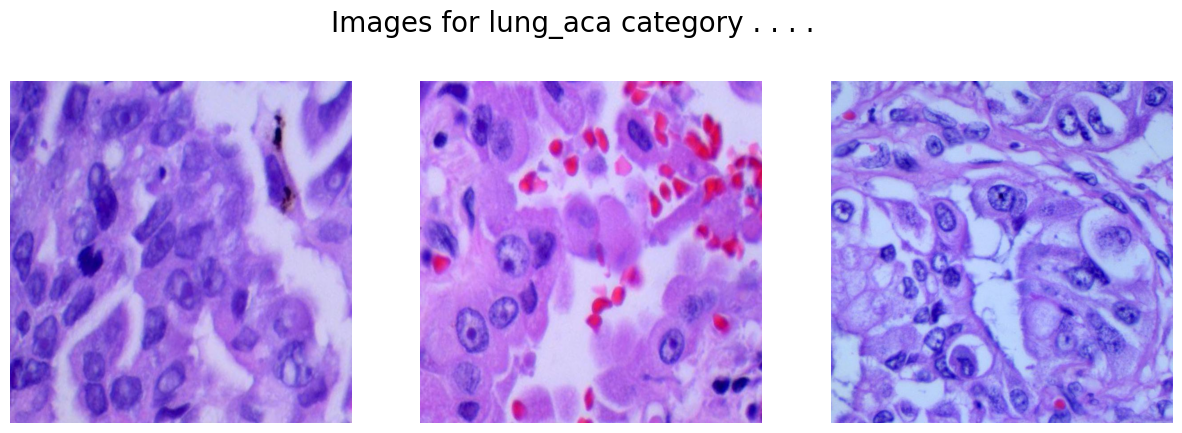

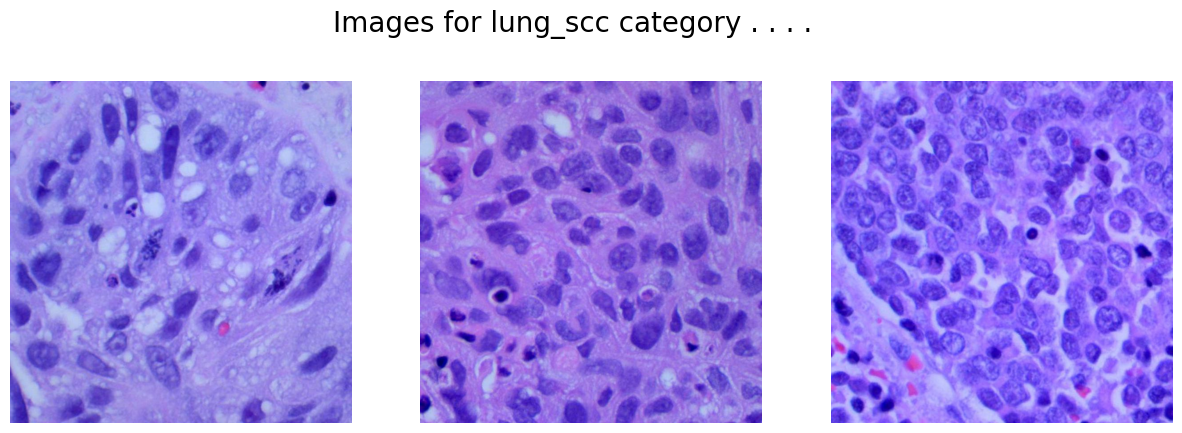

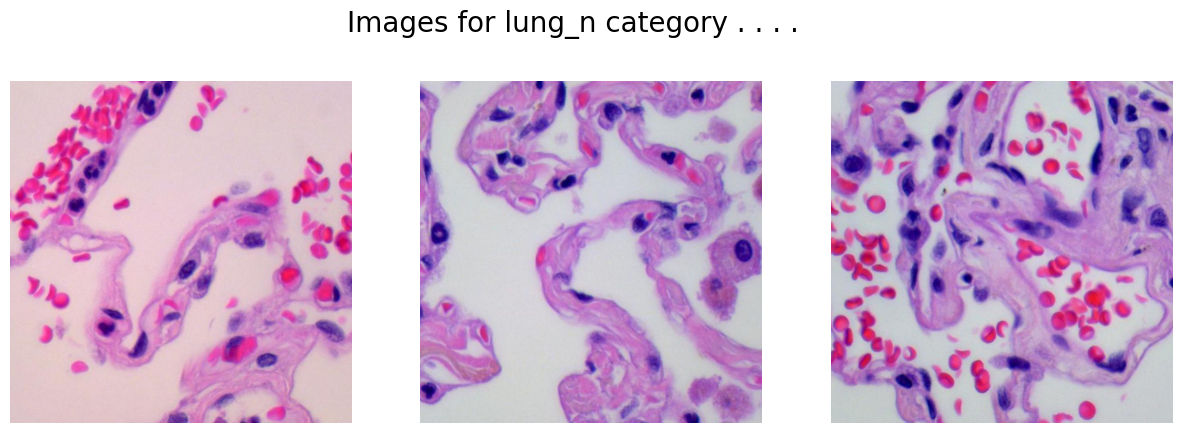

In [4]:
path = '/root/.cache/kagglehub/datasets/subho117/lung-cancer-detection-using-transfer-learning/versions/1/lung_image_sets'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category . . . .',
                 fontsize = 20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [5]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 5
BATCH_SIZE = 64

In [6]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
	input_shape = (IMG_SIZE, IMG_SIZE, 3),
	weights = 'imagenet',
	include_top = False
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
len(pre_trained_model.layers)

311

In [10]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [11]:
last_layer = pre_trained_model.get_layer('mixed7')
output_shape = last_layer.input[0].shape

print('last layer output shape: ', output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 192)


In [12]:
x = layers.Flatten()(last_output)

x = layers.Dense(256,activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(3, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

In [13]:
model.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.90:
      print('\n Validation accuracy has reached upto 90%\
      so, stopping further training.')
      self.model.stop_training = True

es = EarlyStopping(patience = 3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)

In [15]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 74s 278ms/step - accuracy: 0.7938 - loss: 0.5077 - val_accuracy: 0.5533 - val_loss: 1.5633 - learning_rate: 0.0010
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 160ms/step - accuracy: 0.9114 - loss: 0.2235 - val_accuracy: 0.8857 - val_loss: 0.2647 - learning_rate: 0.0010
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step - accuracy: 0.9318 - loss: 0.1790 - val_accuracy: 0.8600 - val_loss: 0.3084 - learning_rate: 0.0010
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9477 - loss: 0.1364
 Validation accuracy has reached upto 90%      so, stopping further training.
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step - accuracy: 0.9477 - loss: 0.1364 - val_accuracy: 0.9430 - val_loss: 0.1627 - learning_rate: 0.0010


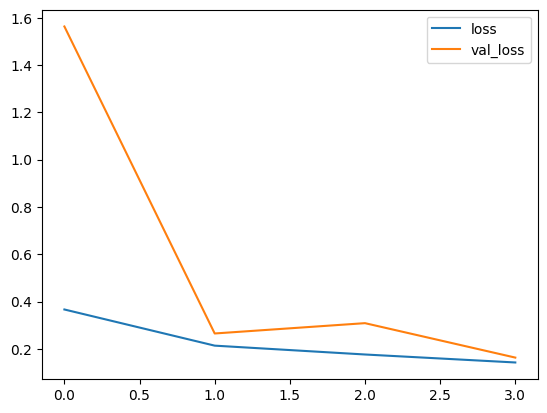

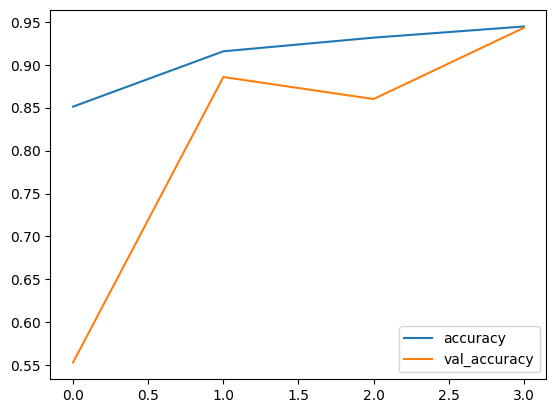

In [16]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [17]:
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step


In [18]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[909,  64,  14],
       [ 56, 921,   0],
       [ 37,   0, 999]])

In [19]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.91      0.92      0.91       987
    lung_scc       0.94      0.94      0.94       977
      lung_n       0.99      0.96      0.98      1036

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000

